# Проект: Прогнозирование потребности в заказах такси

**Оглавление**<a id='toc0_'></a>    
- 1. [Загрузка и подготовка данных](#toc1_)    
  - 1.1. [Вывод по результатам раздела 1](#toc1_1_)    
- 2. [Анализ данных](#toc2_)    
  - 2.1. [Вывод по результатам раздела 2](#toc2_1_)    
- 3. [Обучение моделей](#toc3_)    
  - 3.1. [Создание признаков](#toc3_1_)    
  - 3.2. [Формирование выборок](#toc3_2_)    
  - 3.3. [Выбор моделей](#toc3_3_)    
  - 3.4. [Линейная регрессия](#toc3_4_)    
  - 3.5. [Случайный лес](#toc3_5_)    
  - 3.6. [Градиентный бустинг](#toc3_6_)    
  - 3.7. [Вывод по результатам раздела 3](#toc3_7_)    
- 4. [Проверка на тестовой выборке](#toc4_)    
  - 4.1. [Вывод по результатам раздела 4](#toc4_1_)    
- 5. [Общий вывод](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Задание:**

Заказчиком (компания «Чётенькое такси») предоставлены исторические данные о заказах такси в аэропортах. Количество заказов находится в столбце 'num_orders'.  
Для привлечения большего количества водителей в период пиковой нагрузки, необходимо построить модель для предсказания количества заказов такси на следующий час.  
По требованию Заказчика, значение метрики 'RMSE' на тестовой выборке должно быть не больше 48.

Необходимо:
- загрузить данные и выполнить их ресемплирование по одному часу;
- проанализировать данные;
- обучить разные модели с различными гиперпараметрами, сделать тестовую выборку размером 10% от исходных данных;
- проверить данные на тестовой выборке и сделать выводы.


План работы:
1. Загрузка и подготовка данных.
2. Анализ данных.
3. Обучение моделей.
4. Проверка на тестовой выборке.
5. Общий вывод.

## 1. <a id='toc1_'></a>[Загрузка и подготовка данных](#toc0_)

In [1]:
%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
# подключение библиотек
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import time
from IPython.display import display

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from lightgbm import LGBMRegressor

# константы
RST = 12345 # значение random_state

In [3]:
# фенкция теста Дики-Фуллера по определению стационарности временного ряда
# на входе временной ряд и уровень статистической значимости
def diki_fuller(time_series, alpha):
    adf = adfuller(time_series)
    print('Значение p-value:', adf[1])
    if adf[1] < alpha:
        print('Отвергаем нулевую гипотезу.')
    else:
        print('Не получилось отвергнуть нулевую гипотезу.')
    return

In [4]:
# загрузка файла
try:
    data_all = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except FileNotFoundError:
    data_all = pd.read_csv('D:\Education\Data Science\Проекты курса DS\Проект_12\datasets\\taxi.csv', 
                            index_col=[0], parse_dates=[0])


print('Результат проверки на монотонное возрастание индекса в загруженных данных:', data_all.index.is_monotonic_increasing)

Результат проверки на монотонное возрастание индекса в загруженных данных: True


Индексы уже упорядочены по возрастанию, дополнительная сортировка не требуется.

Сделаем ресэмплинг данных для группировки по 1 часу и обзор получившихся данных.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43



Статистическая информация:


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


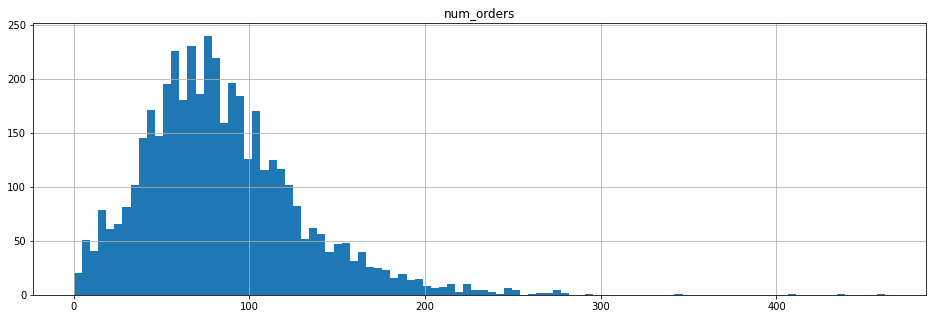

In [5]:
# ресэмплинг по 1 часу
data_all = data_all.resample('1H').sum()

# обзор данных
data_all.info()
display(data_all.head())

# отображение статистической информации
print('\nСтатистическая информация:')
display(data_all.describe())
data_all.hist(bins=100, figsize=(16,5))
plt.show()

### 1.1. <a id='toc1_1_'></a>[Вывод по результатам раздела 1](#toc0_)

Данные успешно загружены, временной ряд сформирован, индексы упорядочены, проведено ресэмплирование до масштаба в 1 час. Отклонений в данных не замечено, распределение целевого признака близко к нормальному.

## 2. <a id='toc2_'></a>[Анализ данных](#toc0_)

Декомпозируем временной ряд на составляющие: тренд, сезонность и остатки. Построим график временного ряда и его составляющих.

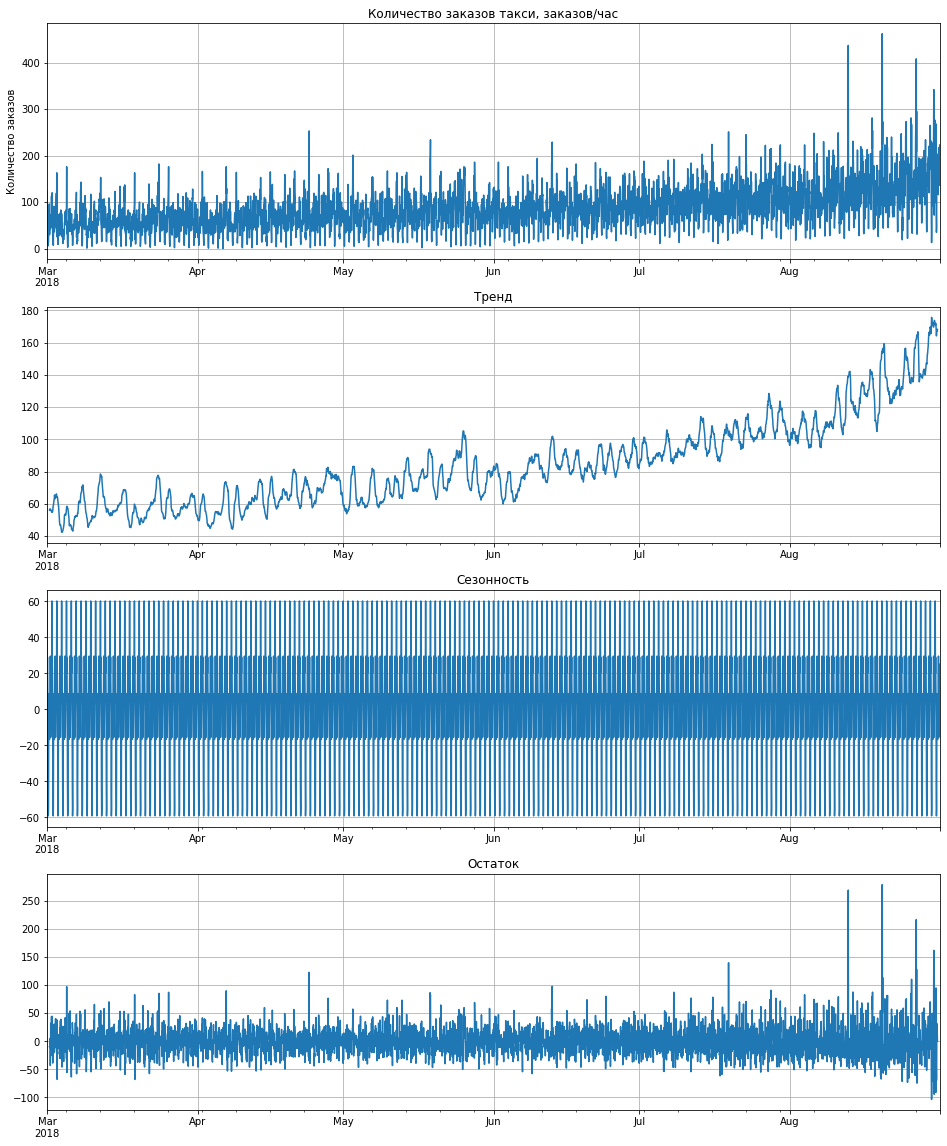

In [6]:
# декомпозиция временного ряда
decomposed = seasonal_decompose(data_all)

# построение графиков
plt.figure(figsize=(16, 20))
plt.subplot(411)
decomposed.observed.plot(ax=plt.gca())
plt.title('Количество заказов такси, заказов/час')
plt.ylabel('Количество заказов')
plt.xlabel('')
plt.grid()

plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('')
plt.grid()

plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('')
plt.grid()

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.xlabel('')
plt.grid()

plt.show()

Визуально временной ряд практически стационарен и имеет очень слабый тренд. До июня изменений тренда практически нет, с июня начинается незначительный рост, который немного усиливается в августе.

Построим график распределения количества заказов по месяцам.

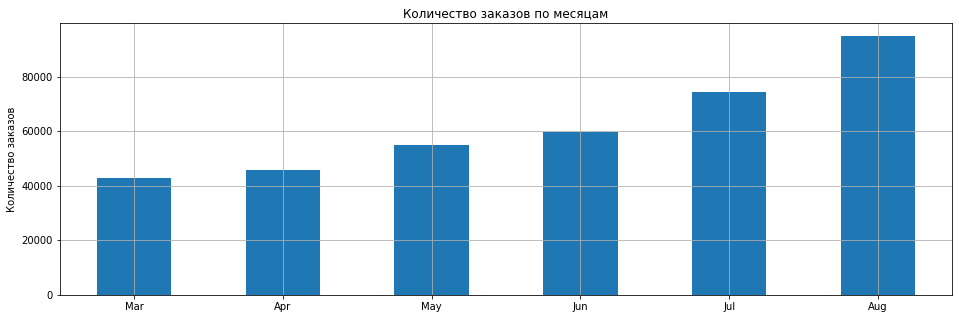

In [7]:
data_all.resample('1M').sum().plot(kind='bar', figsize=(16,5), legend=None)
plt.title('Количество заказов по месяцам')
plt.xlabel('')
plt.xticks(rotation=0, ticks=[0,1,2,3,4,5], labels=['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug'])
plt.ylabel('Количество заказов')
plt.grid()
plt.show()

Наблюдаем рост количества заказов по месяцам.

Чтобы проследить сезонную закономерность, отобразим график сезонности более детально, например, за первые 5 дней апреля.

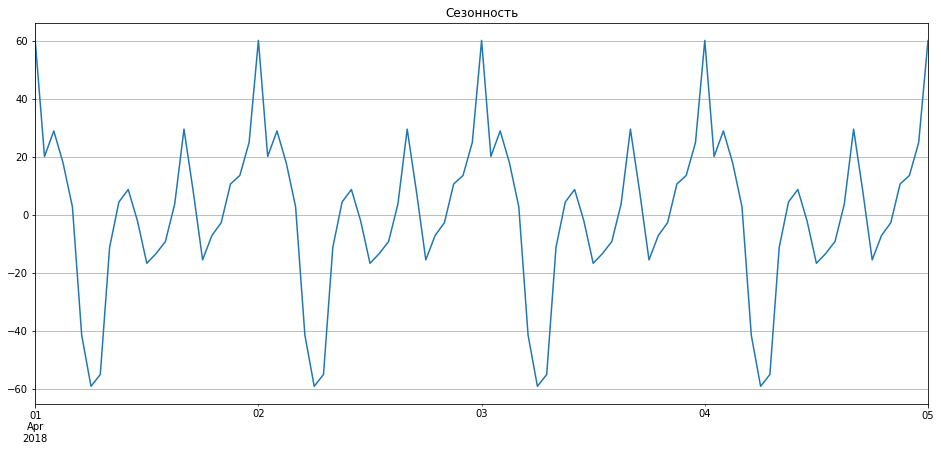

In [8]:
decomposed.seasonal.plot(figsize=(16,7))
plt.title('Сезонность')
plt.xlabel('')
plt.grid()
plt.xlim('2018-04-01', '2018-04-05')
plt.show()

Видим, что у временного ряда есть сезонная закономерность в виде суточных колебаний. Это логично и закономерно для заказов такси. Спрос достигает максимума примерно к полуночи после этого резко падает в ночные часы, достигая минимума в предутреннее время. Затем в течении дня нелинейно растет, вновь достигая своего максимума к следующей полуночи.

Для математической оценки стационарности временного ряда применим тест Дики-Фуллера. В нем нулевая гипотеза $H_0$ предполагает, что временной ряд нестационарный, а альтернативная гипотеза $H_1$ говорит об обратном. Уровень статистической значимости $p-value$ примем равным 5%.

In [9]:
diki_fuller(data_all['num_orders'], .05)

Значение p-value: 0.028940051402612906
Отвергаем нулевую гипотезу.


Тест Дики-Фуллера показывает, что временной ряд при уровне статистической значимости 5% можно считать стационарным.

Результаты теста не совпадают с визуальной оценкой временного ряда, на графиках прослеживалось наличие небольшого роста заказов примерно с середины рассматриваемого периода, усиливающегося в августе.

Проведем тест Дики-Фуллера при уровне статистической значимости 1%.

In [10]:
diki_fuller(data_all['num_orders'], .01)

Значение p-value: 0.028940051402612906
Не получилось отвергнуть нулевую гипотезу.


При уровне статистической значимости 1% нулевую гипотезу отвергнуть не удалось, при данном уровне значимости ряд можно считать нестационарным.

Построим графики автокорреляции и частичной автокорреляции.

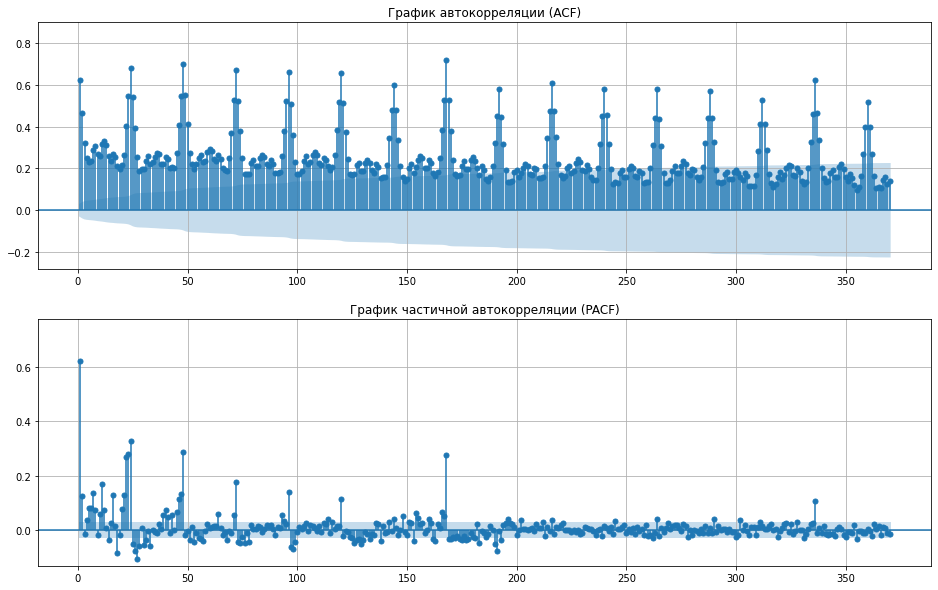

In [11]:
plt.figure(figsize=(16, 10))
plt.subplot(211)
plot_acf(data_all, lags=370, ax=plt.gca(), auto_ylims=True, zero=False, title='График автокорреляции (ACF)')
plt.grid()

plt.subplot(212)
plot_pacf(data_all, lags=370, ax=plt.gca(), auto_ylims=True, zero=False, method='ywm', 
          title='График частичной автокорреляции (PACF)')
plt.grid()
plt.show()

Положительные, равномерно убывающие значения корреляции лагов на графике автокорреляции говорят о наличии тренда. Также на графиках прослеживается наличие еждневной и еженедельной периодичности.

На графиках выделяются:
- первый лаг;
- лаги, кратные 24, соответствующие ежедневной периодичности;
- лаги, кратные 168, соответствующие недельной периодичности.

Наибольшую корреляцию и влияние имеют:
- первый лаг;
- лаги, кратные 24 до 120-го включительно;
- 168 и 336 лаги. 

### 2.1. <a id='toc2_1_'></a>[Вывод по результатам раздела 2](#toc0_)

Анализ временного ряда показал наличие следующих закономерностей:

- Наличие тренда визуально прослеживается на графиках тренда при декомпозиции временного ряда, графике количества заказов в разрезе месяцев и на графике автокорреляции. Тест Дики-Фуллера при 5% статистической значимости говорит о стационарности временного ряда, а при 1% статистической значимости о нестационарности временного ряда. Такая ситуация вызвана слабым трендом, начинающимся только с середины рассматриваемого периода.
- Наличие сезонности:
    - ежедневная периодичность;
    - еженедельная периодичность.
- Наибольшую корреляцию и влияние имеют: первый лаг; лаги, кратные 24 до 120-го включительно; 168 и 336 лаги.

## 3. <a id='toc3_'></a>[Обучение моделей](#toc0_)

### 3.1. <a id='toc3_1_'></a>[Создание признаков](#toc0_)

Для временного рядя можно создать три вида признаков:
- календарные признаки;
- отстающие значения (лаги);
- скользящие средние.

Для временного ряда, представляющего собой количество заказов такси в течении часа за период в несколько месяцев, с учетом проведенного анализа данных, для обучения моделей целесообразно использовать следующие признаки:
- из календарных признаков: день недели и месяц;
- из признаков отстающих значений (лагов): лаги номер 1, 24, 48 и 168;
- из признаков скользящих средних: скользящая средняя за 7 дней.

Создадим перечисленные признаки.

In [13]:
# функция создания признаков для временного ряда
# на входе: временной ряд, списки календарных признаков, отстающих значений (лагов) и скользящих средних
# на выходе: новый датасет с добавленными к временному ряду признаками
def create_features(df_out, cal, lag, rol):
    df = df_out.copy()
    # создание календарных признаков
    for _ in cal:
        df_out[_] = getattr(df_out.index, _)
    # создание лагов
    for _ in lag:
        df_out['lag_{}'.format(_)] = df_out.iloc[:,0].shift(_)
    # создание скользящих средних
    for _ in rol:
        df_out['rolling_mean_{}'.format(_)] = df_out.iloc[:,0].shift().rolling(_).mean()
    return df_out

In [14]:
# создание признаков
data = create_features(data_all, ['dayofweek', 'month'], [1, 24, 48, 168], [7])
data.info()
display(pd.concat([data.head(8), data.sample(5)]))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_orders      4416 non-null   int64  
 1   dayofweek       4416 non-null   int64  
 2   month           4416 non-null   int64  
 3   lag_1           4415 non-null   float64
 4   lag_24          4392 non-null   float64
 5   lag_48          4368 non-null   float64
 6   lag_168         4248 non-null   float64
 7   rolling_mean_7  4409 non-null   float64
dtypes: float64(5), int64(3)
memory usage: 310.5 KB


,num_orders,dayofweek,month,lag_1,lag_24,lag_48,lag_168,rolling_mean_7
datetime,,,,,,,,
2018-03-01 00:00:00,124,3,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,3,85.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,3,66.0,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,3,43.0,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,3,6.0,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,3,12.0,NaN,NaN,NaN,58.142857
2018-08-21 05:00:00,48,1,8,216.0,118.0,73.0,47.0,189.428571


Построим и проанализируем диаграммы рассеяния.

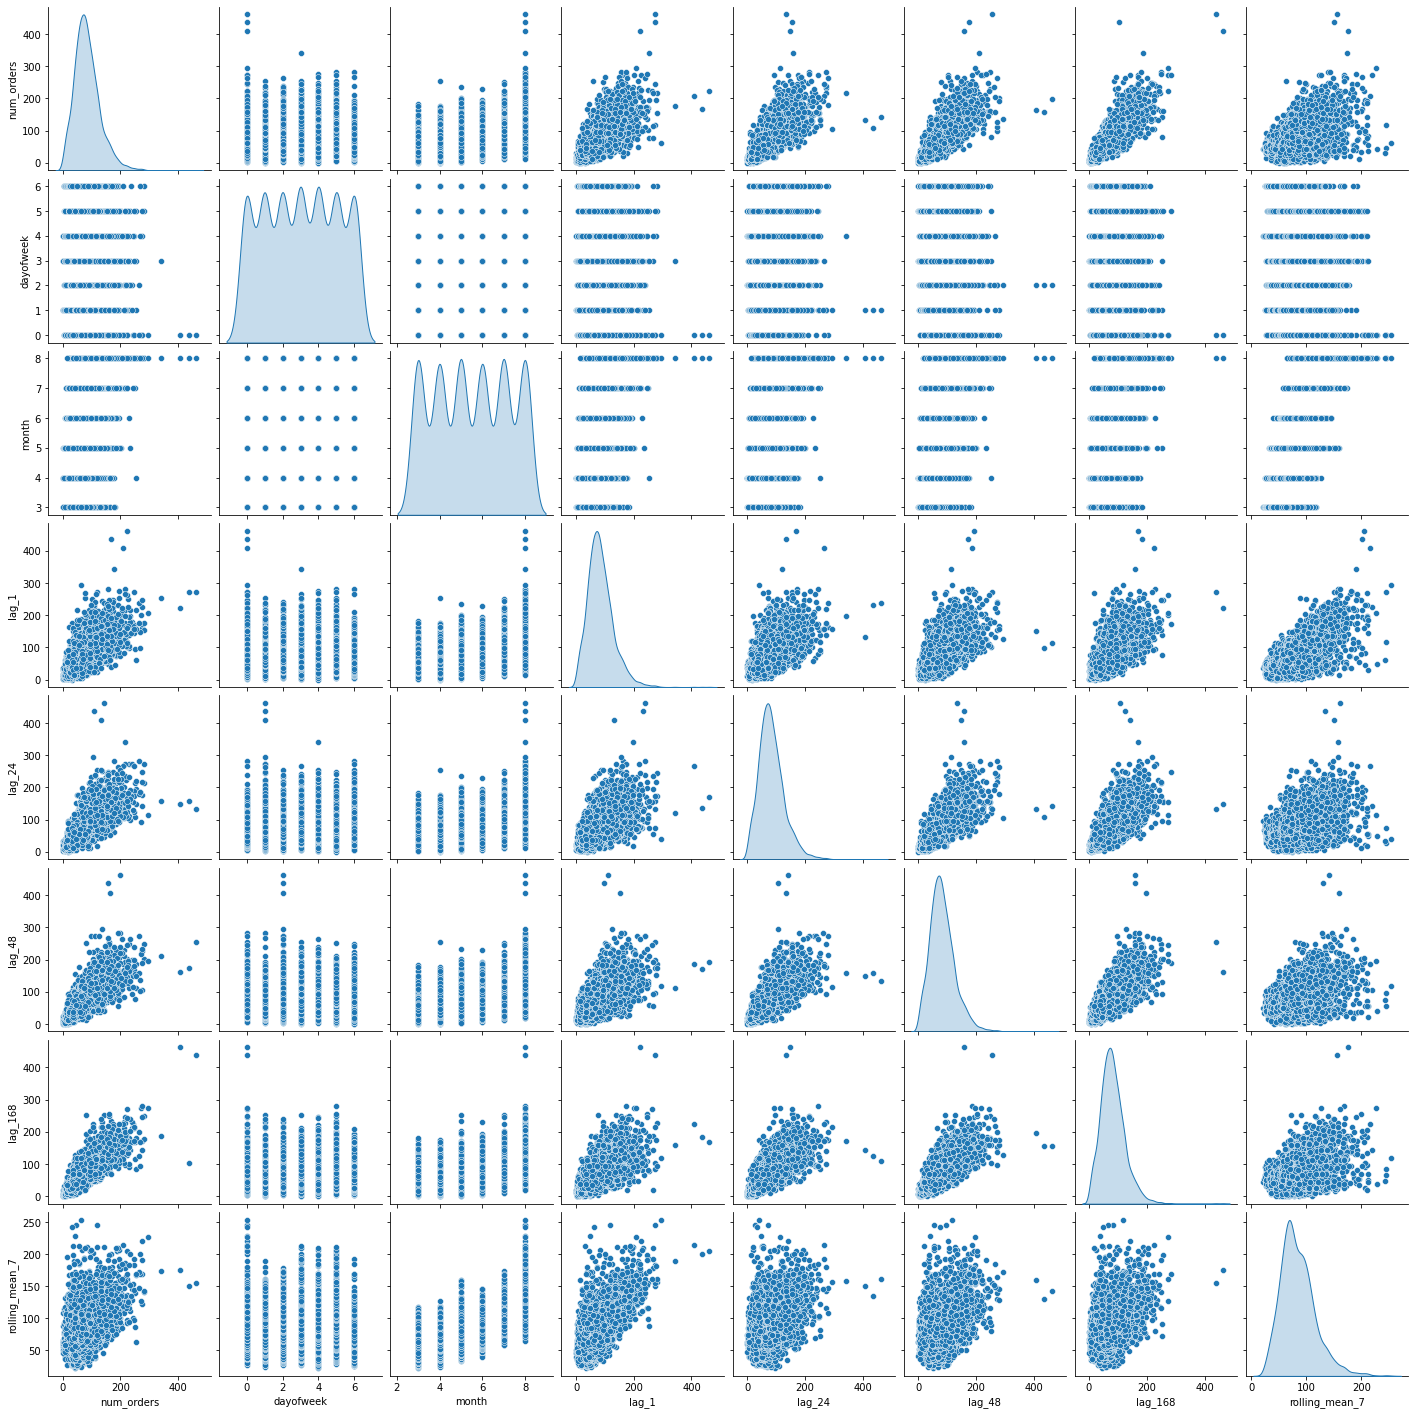

In [16]:
ax = sns.pairplot(data, diag_kind='kde')
plt.show()

Часть признаков (в частности день недели `dayofweek` и месяц `month`) имеют форму распределения, не являющуюся с нормальным, в их значениях наблюдается дискретность. В такой ситуации для определения корреляции лучше использовать критерий Спирмена.

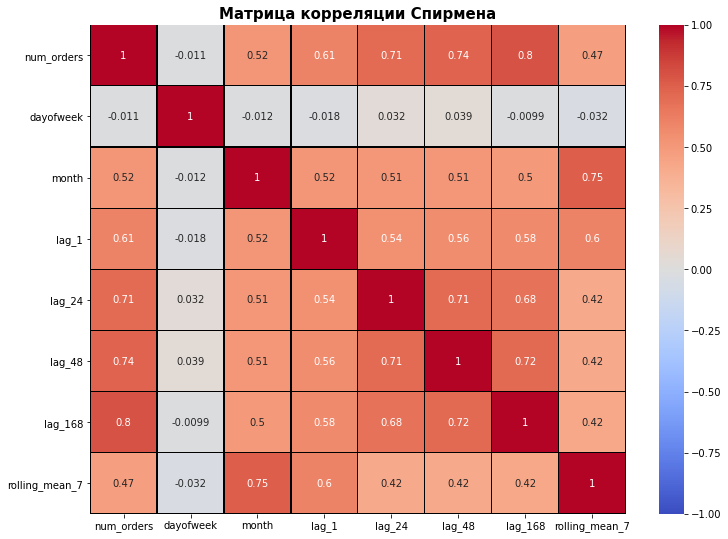

In [17]:
# построение матрицы корреляции Спирмена
plt.figure(figsize=(12, 9))
sns.heatmap(data.corr(method='spearman'), vmin=-1, vmax=+1, cmap='coolwarm', annot=True, linewidths=.1, linecolor='black')
plt.yticks(rotation=0)
plt.title('Матрица корреляции Спирмена', size=15, fontweight='bold')
plt.show()

Видим, что между признаками (за исключением дня недели `dayofweek`) существует корреляция среднего и выше среднего уровня.

### 3.2. <a id='toc3_2_'></a>[Формирование выборок](#toc0_)

Разделим данные на обучающую (`train`) и тестовую (`test`) выборки, в каждой из которых разнесем в отдельные выборки признаки (`features`) и целевой признак (`target`).

Горизонт прогнозирования (тестовая выборка) должен составить 10% от исходных данных.

В моделях предполагается использовать кросс-валидацию, поэтому выделение отдельной валидационной выборки не требуется.

In [18]:
#features = data.drop('num_orders', axis=1)
#target = data['num_orders']
#features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.1, 
#                                                                            shuffle=False, random_state=RST)


# разделение на обучающую и тестовую выборки
train, test = train_test_split(data, test_size=.1, shuffle=False, random_state=RST)

# удаление строк с пропусками в обучающей выборке
train = train.dropna()
# изменение типов данных
pd.options.mode.chained_assignment = None
for _ in ['lag_1', 'lag_24', 'lag_48', 'lag_168']:
    train.loc[:, [_]] = train.loc[:, [_]].astype('int64')
    test.loc[:, [_]] = test.loc[:, [_]].astype('int64')

# просмотр результата
train.info()
display(pd.concat([train.head(5), train.sample(5)]))
test.info()
display(pd.concat([test.head(5), test.sample(5)]))

# разделение признаков и целевого признака в обучающей и тестовой выборках
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

# вывод итоговой информации о выборках
print(f'''
Обучающая выборка (features_train, target_train):
    - признаки {features_train.shape};
    - целевой признак ({target_train.shape[0]}).
Тестовая выборка (features_test, target_test):
    - признаки {features_test.shape};
    - целевой признак ({target_test.shape[0]}).
''')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3806 entries, 2018-03-08 00:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_orders      3806 non-null   int64  
 1   dayofweek       3806 non-null   int64  
 2   month           3806 non-null   int64  
 3   lag_1           3806 non-null   int64  
 4   lag_24          3806 non-null   int64  
 5   lag_48          3806 non-null   int64  
 6   lag_168         3806 non-null   int64  
 7   rolling_mean_7  3806 non-null   float64
dtypes: float64(1), int64(7)
memory usage: 267.6 KB


,num_orders,dayofweek,month,lag_1,lag_24,lag_48,lag_168,rolling_mean_7
datetime,,,,,,,,
2018-03-08 00:00:00,143,3,3,94,100,42,124,86.000000
2018-03-08 01:00:00,78,3,3,143,121,75,85,99.571429
2018-03-08 02:00:00,65,3,3,78,24,36,71,96.571429
2018-03-08 03:00:00,68,3,3,65,66,49,66,98.714286
2018-03-08 04:00:00,60,3,3,68,73,30,43,97.571429
2018-07-22 19:00:00,55,6,7,52,87,64,87,109.857143
2018-08-01 16:00:00,165,2,8,113,100,127,134,94.571429
2018-06-25 17:00:00,97,0,6,106,103,88,75,91.857143
2018-05-23 04:00:00,77,2,5,79,60,70,88,102.714286


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_orders      442 non-null    int64  
 1   dayofweek       442 non-null    int64  
 2   month           442 non-null    int64  
 3   lag_1           442 non-null    int64  
 4   lag_24          442 non-null    int64  
 5   lag_48          442 non-null    int64  
 6   lag_168         442 non-null    int64  
 7   rolling_mean_7  442 non-null    float64
dtypes: float64(1), int64(7)
memory usage: 31.1 KB


,num_orders,dayofweek,month,lag_1,lag_24,lag_48,lag_168,rolling_mean_7
datetime,,,,,,,,
2018-08-13 14:00:00,102,0,8,119,104,73,98,111.142857
2018-08-13 15:00:00,175,0,8,102,149,143,117,120.142857
2018-08-13 16:00:00,144,0,8,175,153,174,204,132.142857
2018-08-13 17:00:00,152,0,8,144,115,122,133,133.142857
2018-08-13 18:00:00,104,0,8,152,78,62,85,132.571429
2018-08-23 22:00:00,130,3,8,182,115,105,143,144.000000
2018-08-21 14:00:00,121,1,8,68,112,113,112,100.857143
2018-08-14 21:00:00,119,1,8,84,160,135,101,111.714286
2018-08-20 15:00:00,223,0,8,112,167,146,175,119.857143



Обучающая выборка (features_train, target_train):
    - признаки (3806, 7);
    - целевой признак (3806).
Тестовая выборка (features_test, target_test):
    - признаки (442, 7);
    - целевой признак (442).



### 3.3. <a id='toc3_3_'></a>[Выбор моделей](#toc0_)

Целевой признак количественный, будем обучать и анализировать следующие модели:
- Линейная регрессия. Простая модель линейной регрессии для быстрой оценки ситуации (`LinearRegression`).
- Случайный лес (`RandomForestRegressor`). Это ансамбль из моделей типа решающее дерево (`DecisionTreeRegressor`) в котором результаты отдельных деревьев усредняются, что позволяет снизить дисперсию и при этом оставаться устойчивым к переобучению.
- Градиентный бустинг (`LightGBM`). Это также ансамбль из простых моделей типа решающее дерево в котором каждая последующая базовая модель учитывает ошибку предудущей, тем самым минимизируется ошибка ансамбля. Градиентный бустинг `LightGBM` в отличии от других моделей градиентного бустинга строит несимметричные деревья ориентируясь на бОльшую величину градиента и имеет более высокую скорость обучения, сохряняя при этом высокую точность.

Масштабирование количественных признаков будем осуществлять с помощью `StandardScaler`. Подбор гиперпараметров осуществим с помощью `GridSearchCV` и кросс-валидации. Мы исследуем временной ряд, для исключения утечки данных нельзя нарушать последовательность значений в выборках для кросс-валидации, поэтому будем использовать `TimeSeriesSplit`. Для создания сквозного процесса применим пайплайн `Pipeline`.

В качестве метрики используем RMSE, значение которой в соответствии с заданием не должно превышать 48.

Для обучения моделей, подбора гиперпараметров и измерения RMSE создадим пользовательскую функцию `model_fit`.

In [19]:
# функция обучения модели
# на входе: созданная модель, выборки с признаками и целевым признаком,
# гиперпараметры для подбора и количество итераций кроссвалидации
# на выходе: обученная модель, её лучший RMSE и параметры
def model_fit(model_type, features, target, param_grid, cv):
    # засекаем время
    start_time = time.time()
    # создание пайплайн с масштабированием и моделью
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model_type)
        ])
    # подбор гиперпараметров с использованием кросс-валидации
    tscv = TimeSeriesSplit(n_splits=cv)
    model = GridSearchCV(pipe, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1, verbose=1)
    model.fit(features, target)
    rmse = -model.best_score_
    param = model.best_params_
    # подсчет времени выполнения
    time_fit = time.time() - start_time
    # вывод результатов
    print(f'''
Лучшие гиперпараметры:{pd.DataFrame.from_dict(param, orient='index').rename(columns={0:''})}
RMSE: {rmse:0.2f}
Время обучения: {time_fit:0.1f} сек. ({time.strftime("%H:%M:%S", time.gmtime(time_fit))})''')
    return model, rmse, param, time_fit

### 3.4. <a id='toc3_4_'></a>[Линейная регрессия](#toc0_)

Для модели простой линейной регрессии практически нет гиперпараметров для подбора. Выполним с помощью подготовленной пользовательской функции `model_fit` масштабирование признаков, обучим с применением кроссвалидации и измерим метрику RMSE.

In [20]:
print('Модель "линейная регрессия"')
# гиперпараметр для подбора
param_grid = [{
    'regressor__fit_intercept': [True, False]
    }]

lg_mod, lg_rmse, lg_param, lg_time_fit = model_fit(LinearRegression(), features_train, target_train, param_grid, 5)

Модель "линейная регрессия"
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Лучшие гиперпараметры:                              
regressor__fit_intercept  True
RMSE: 22.65
Время обучения: 0.1 сек. (00:00:00)


### 3.5. <a id='toc3_5_'></a>[Случайный лес](#toc0_)

Для модели случайный лес (`RandomForestRegressor`) осуществим подбор четырех гиперпараметров, оказывающих основное влияние на результат модели: количество деревьев (`n_estimators`), глубина дерева (`max_depth`), максимальное количество признаков (`max_features`) и минимальное число объектов в листе (`min_samples_leaf`). Остальные гиперпараметры оставим в значениях по умолчанию.

In [21]:
print('Модель "случайный лес"')
# гиперпараметры и их диапазоны для подбора
param_grid = [{
    'regressor__n_estimators': [50, 100, 300, 400],
    'regressor__max_depth': [3, 6, 9, 12],
    'regressor__max_features': ['log2', 'sqrt', 1],
    'regressor__min_samples_leaf': [1, 2, 4, 8]
    }]

rfr_mod, rfr_rmse, rfr_param, rfr_time_fit = model_fit(RandomForestRegressor(random_state=RST), 
                                                       features_train, target_train, param_grid, 5)

Модель "случайный лес"
Fitting 5 folds for each of 192 candidates, totalling 960 fits

Лучшие гиперпараметры:                                 
regressor__max_depth           12
regressor__max_features      log2
regressor__min_samples_leaf     4
regressor__n_estimators       300
RMSE: 22.78
Время обучения: 362.6 сек. (00:06:02)


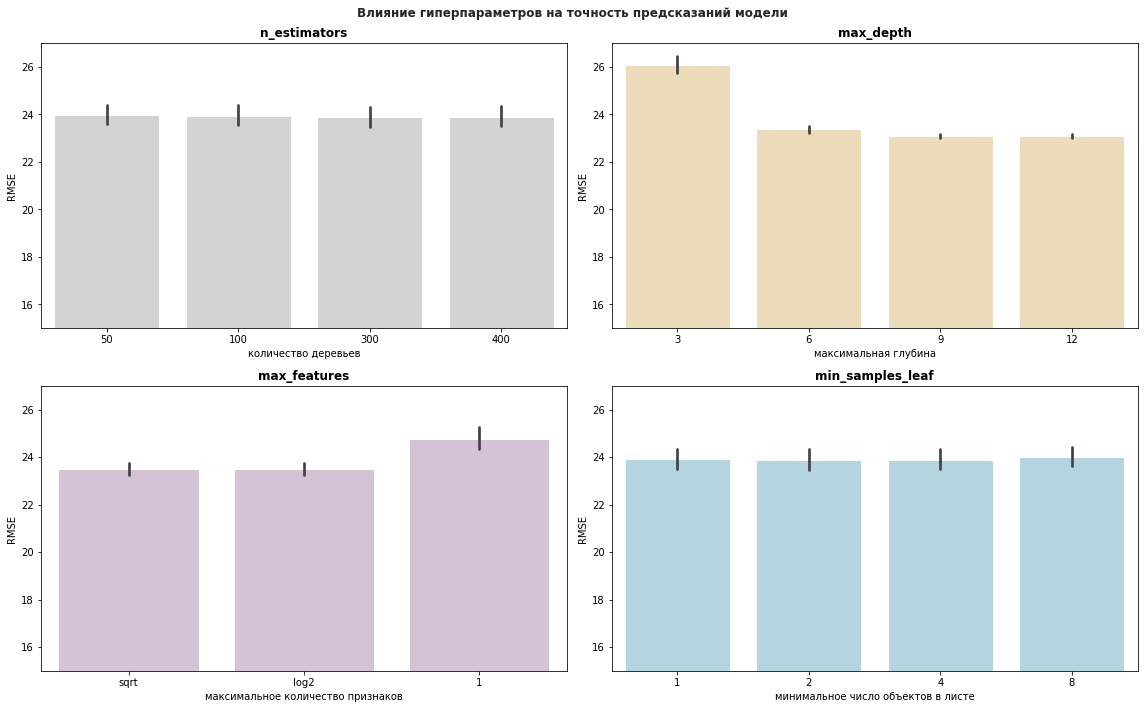

In [22]:
# построение графиков влияния подбираемых гиперпараметров на модель
res_rs = pd.DataFrame(rfr_mod.cv_results_).sort_values(by='rank_test_score')
res_rs.mean_test_score = - res_rs.mean_test_score
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.set_style("whitegrid")
fig.suptitle('Влияние гиперпараметров на точность предсказаний модели', fontweight='bold')
sns.barplot(x='param_regressor__n_estimators', y='mean_test_score', data=res_rs, ax=axes[0,0], color='lightgrey')
axes[0,0].set (xlabel='количество деревьев', ylabel='RMSE')
axes[0,0].set_title(label = 'n_estimators', fontweight='bold')
axes[0,0].set_ylim([15, 27])
sns.barplot(x='param_regressor__max_depth', y='mean_test_score', data=res_rs, ax=axes[0,1], color='wheat')
axes[0,1].set (xlabel='максимальная глубина', ylabel='RMSE')
axes[0,1].set_title(label = 'max_depth', fontweight='bold')
axes[0,1].set_ylim([15, 27])
sns.barplot(x='param_regressor__max_features', y='mean_test_score', data=res_rs, ax=axes[1,0], color='thistle')
axes[1,0].set (xlabel='максимальное количество признаков', ylabel='RMSE')
axes[1,0].set_title(label = 'max_features', fontweight='bold')
axes[1,0].set_ylim([15, 27])
sns.barplot(x='param_regressor__min_samples_leaf', y='mean_test_score', data=res_rs, ax=axes[1,1], color='lightblue')
axes[1,1].set (xlabel='минимальное число объектов в листе', ylabel='RMSE')
axes[1,1].set_title(label = 'min_samples_leaf', fontweight='bold')
axes[1,1].set_ylim([15, 27])
fig.tight_layout()
plt.show()

Гиперпараметр количество деревьев (`n_estimators`) слабо улучшает точность модели по мере увеличения значений, в районе 300 точность модели достигает насыщения, после чего дальнейшее увеличение гиперпараметра нецелесообразно.

Гиперпараметр глубина дерева (`max_depth`) также улучшает точность модели по мере увеличения и достигает насыщения в диапазоне значений 8 - 10.

Гиперпараметр максимальное количество признаков (`max_features`) показывает сходную точность при значениях `log2` и `sqrt`, при значении `1`, когда задействованы все признаки, точность хуже.

Гиперпараметр минимальное число объектов в листе (`min_samples_leaf`) оказывает слабое влияние на точность, лучшая точность модели получается при значении 4.

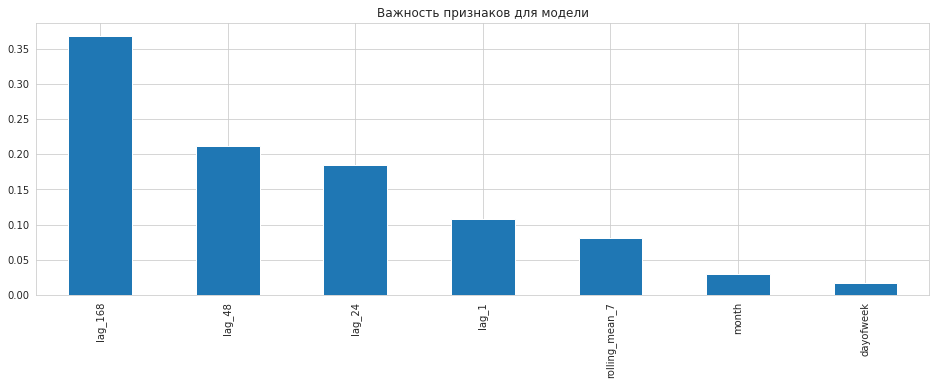

In [23]:
# построение графика важности признаков для модели
pd.Series(rfr_mod.best_estimator_.named_steps['regressor'].feature_importances_, features_train.columns
         ).sort_values(ascending=False).plot(kind='bar', figsize=(16,5), title='Важность признаков для модели')
plt.show()

Самым важным признаком модель определила `lag_168` - недельная периодичность. Следом по важности идут остальные признаки отстающих значений (лагов). За ними признак скользящей средней. На последних местах по важности находятся календарные признаки.

### 3.6. <a id='toc3_6_'></a>[Градиентный бустинг](#toc0_)

Осуществим подбор четырех гиперпараметров, оказывающих основное влияние на результат модели, гиперпараметров: скорость обучения (`learning_rate`), максимальная глубина дерева (`max_depth`), количество деревьев (`n_estimators`) и тип алгоритма (`boosting_type`).

Гиперпараметру количество листьев в дереве (`num_leaves`) установим значение по умолчанию, а гиперпараметру тип алгоритма `boosting_type` значение `goss`. Влияние этих гиперпараметров рассматривалось отдельно, указанные значения давали лучший результат, строки этого исследования в коде закомментированы. Гиперпараметр `num_leaves` при изменении от `20` до `200`, включая значение по умолчанию `31`, не оказывал влияния на точность модели. Гиперпараметр тип алгоритма `boosting_type` при значениях `gbdt` и `goss` показывал схожие значения точности модели (чуть лучше при значении `goss`), при значении `dart` точность существенно ухудшалась и возрастало время обучения.

In [24]:
print('Модель "градиентный бустинг"')
# гиперпараметры и их диапазоны для подбора
param_grid = [{
    'regressor__learning_rate': [.02, .03, .05, .1, .3],
    'regressor__max_depth': [1, 2, 4, 8],
    'regressor__n_estimators': [50, 100, 200, 300],
#    'regressor__boosting_type': ['gbdt', 'dart', 'goss'],
#    'regressor__num_leaves': [20, 31, 100, 200]
    }]

lgbmr_mod, lgbmr_rmse, lgbmr_param, lgbmr_time_fit = model_fit(LGBMRegressor(boosting_type='goss', random_state=RST, 
                                                                             num_threads=1, n_jobs=None), 
                                                               features_train, target_train, param_grid, 5)

Модель "градиентный бустинг"
Fitting 5 folds for each of 80 candidates, totalling 400 fits

Лучшие гиперпараметры:                                
regressor__learning_rate    0.02
regressor__max_depth        2.00
regressor__n_estimators   300.00
RMSE: 22.85
Время обучения: 25.7 сек. (00:00:25)


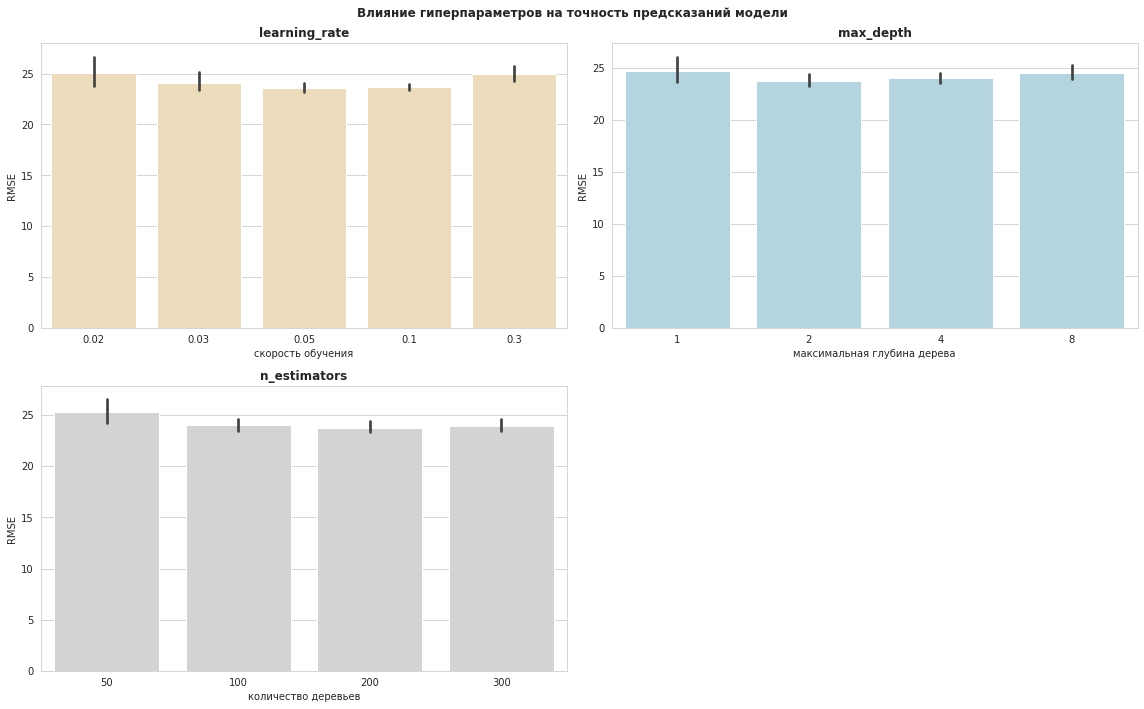

In [25]:
# построение графиков влияния подбираемых гиперпараметров на модель
res_lgbmr = pd.DataFrame(lgbmr_mod.cv_results_).sort_values(by='rank_test_score')
res_lgbmr.mean_test_score = - res_lgbmr.mean_test_score
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
sns.set_style("whitegrid")
fig.suptitle('Влияние гиперпараметров на точность предсказаний модели', fontweight='bold')
sns.barplot(x='param_regressor__learning_rate', y='mean_test_score', data=res_lgbmr, ax=axes[0,0], color='wheat')
axes[0,0].set (xlabel='скорость обучения', ylabel='RMSE')
axes[0,0].set_title(label = 'learning_rate', fontweight='bold')
sns.barplot(x='param_regressor__max_depth', y='mean_test_score', data=res_lgbmr, ax=axes[0,1], color='lightblue')
axes[0,1].set (xlabel='максимальная глубина дерева', ylabel='RMSE')
axes[0,1].set_title(label = 'max_depth', fontweight='bold')
sns.barplot(x='param_regressor__n_estimators', y='mean_test_score', data=res_lgbmr, ax=axes[1,0], color='lightgrey')
axes[1,0].set (xlabel='количество деревьев', ylabel='RMSE')
axes[1,0].set_title(label = 'n_estimators', fontweight='bold')
#sns.barplot(x='param_regressor__boosting_type', y='mean_test_score', data=res_lgbmr, ax=axes[1,1], color='moccasin')
#axes[1,1].set (xlabel='тип алгоритма', ylabel='RMSE')
#axes[1,1].set_title(label = 'boosting_type', fontweight='bold')
#sns.barplot(x='param_regressor__num_leaves', y='mean_test_score', data=res_lgbmr, ax=axes[2,0], color='thistle')
#axes[2,0].set (xlabel='количество листьев в дереве', ylabel='RMSE')
#axes[2,0].set_title(label = 'num_leaves', fontweight='bold')
fig.delaxes(axes[1,1])
fig.tight_layout()
plt.show()

Гиперпараметр скорость обучения (`learning_rate`) при изменении значений от 0,02 до 0,3 дает улучшение точности модели, лучшая точность при значении гиперпараметра 0,02. 

При изменении гиперпараметра максимальная глубина дерева (`max_depth`) уже на значении 2 происходит насыщение и дальнейшее увеличение значения гиперпараметра приводит к ухудшению точности модели.

При увеличении гиперпараметра количество деревьев (`n_estimators`) точность модели улучшается, насыщение происходит на уровне 200, после чего дальнейшее увеличение значений гиперпараметра нецелесообразно.

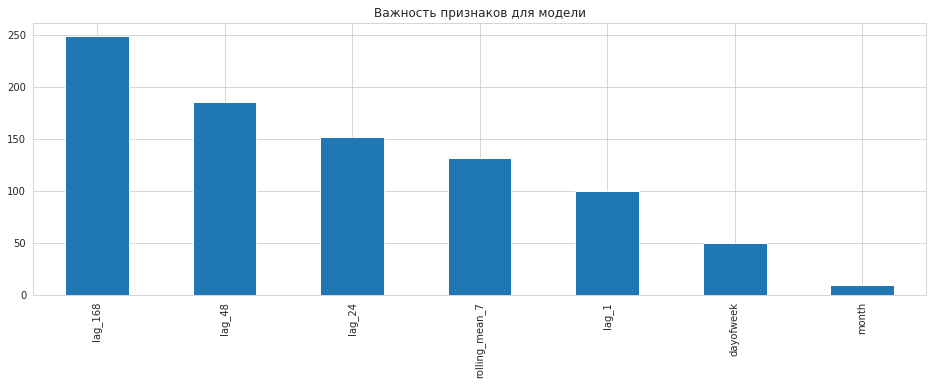

In [26]:
# построение графика важности признаков для модели
pd.Series(lgbmr_mod.best_estimator_.named_steps['regressor'].feature_importances_, features_train.columns
         ).sort_values(ascending=False).plot(kind='bar', figsize=(16,5), title='Важность признаков для модели')
plt.show()

Самым важным признаком модель градиентного бустинга, также как и модель случайных лес, определила lag_168 - недельная периодичность. Следом по важности идут остальные признаки отстающих значений (лагов), признак скользящей средней и календарные признаки.

### 3.7. <a id='toc3_7_'></a>[Вывод по результатам раздела 3](#toc0_)

Рассмотрев три вида моделей можно сделать следующие выводы:
- Все модели показали похожую точность, различия составляют в десятых и сотых долях.
- Линейная регрессия очень быстро отрабатывает по стравнению с другими типами моделей, при этом дает аналогичную точность предсказаний.
- Из двух моделей случайный лес и градиентный бустинг при практически одинаковой точности и примерно одинаковом количестве вариантов подбираемых гиперпараметров, последняя имеет более высокую скорость обучения.

## 4. <a id='toc4_'></a>[Проверка на тестовой выборке](#toc0_)

Для окончательного выбора модели соберем все результаты в таблицу.

In [27]:
models = pd.DataFrame(data=[
        [lg_time_fit, lg_rmse],
        [rfr_time_fit, rfr_rmse],
        [lgbmr_time_fit, lgbmr_rmse]],
         index=['линейная регрессия (LinearRegression)', 'случайный лес (RandomForestRegressor)', 
                'градиентный бустинг (LGBMRegressor)'],
         columns=['время обучения, сек.', 'качество предсказания (RMSE)']).round(2)
display(models)

,"время обучения, сек.",качество предсказания (RMSE)
линейная регрессия (LinearRegression),0.10,22.65
случайный лес (RandomForestRegressor),362.60,22.78
градиентный бустинг (LGBMRegressor),25.71,22.85


Видим, что все модели имеют практически одинаковую точность, все соответствуют требованию по качеству предсказаний (RMSE < 48), разница только во времени обучения.

Лучшей по качеству предсказания и по времени обучения является `LinearRegression`. Проверим эту модель на тестовой выборке.

In [28]:
print(f'RMSE на тестовой выборке: {mean_squared_error(target_test, lg_mod.predict(features_test), squared=False):0.2f}')

RMSE на тестовой выборке: 35.21


Качество предсказаний модели на тестовой выборке хуже, чем на обучающей, но соответствует требованию RMSE < 48.

Визуализируем финальные предсказания, отобразив графики исходного и предсказанных рядов.

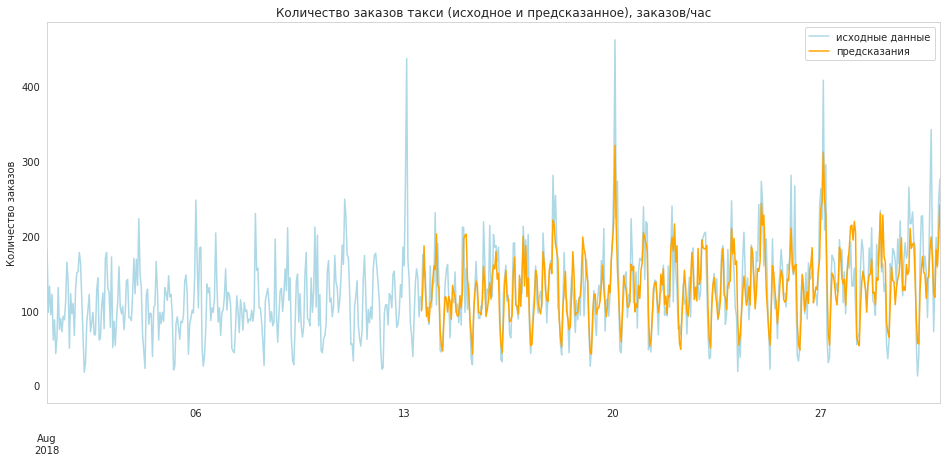

In [29]:
plt.figure(figsize=(16, 7))
target_train.plot(label='исходные данные', color='lightblue')
target_test.plot(label='', color='lightblue')
pd.Series(lg_mod.predict(features_test), index=target_test.index).plot(label='предсказания', color='orange')
plt.title('Количество заказов такси (исходное и предсказанное), заказов/час')
plt.ylabel('Количество заказов')
plt.xlabel('')
plt.xlim('2018-08-01', '2018-08-31')
plt.legend()
plt.grid()

### 4.1. <a id='toc4_1_'></a>[Вывод по результатам раздела 4](#toc0_)

Рассмотрено три модели разных типов:
- линейная регрессия;
- случайный лес;
- градиентный бустинг.

Все модели обучались на одинаково подготовленной выборке, для всех был осуществлен подбор наиболее влияющих на качество предсказаний гиперпараметров. В процессе работы для каждой модели проведены расчет метрики RMSE и измерения времени на этапе обучения.

По совокупности факторов наиболее соответствующей требованиям Заказчика является модель линейной регрессии. Данная модель была проверена на тестовой выборке, где показала хорошее качество предсказаний, соответствующее требованию RMSE < 48.

## 5. <a id='toc5_'></a>[Общий вывод](#toc0_)

В ходе реализации проекта были успешно загружены исходные данные и сформирован временной ряд. В рамках предподготовки упорядочены индексы, проведено ресэмплирование до масштаба в 1 час. Отклонений в данных не замечено, распределение целевого признака близко к нормальному. Проведенный анализ временного ряда показал наличие следующих закономерностей:
- Наличие тренда, которое визуально прослеживается на графиках: декомпозиции временного ряда; количества ежемесячных заказов; автокорреляции. Тест Дики-Фуллера при 1% статистической значимости не опровергает предположение нестационарности временного ряда. При этом следует отметить, что трендом слабый, начинающимся примерно с середины рассматриваемого периода.
- Наличие двух видов сезонности: ежедневной и еженедельной.
- Наибольшую корреляцию и влияние имеют: лаг 1; лаги, кратные 24 до 120-го включительно; лаги 168 и 336.

Для обучения выбраны модели трех разных типов: линейная регрессия, случайный лес и градиентный бустинг. Для обучения использована типовая схема обучения, реализованная в виде пользовательской функции и состоящая из следующих этапов:
- предварительное масштабирование количественных признаков с помощью `StandardScaler`;
- подбор гиперпараметров на базе `GridSearchCV`, включающий кросс-валидацию `TimeSeriesSplit` и расчет метрики RMSE;
- сквозной процесс между этапами организован с помощью `Pipeline`.

По результатам анализа и тестирования моделей можно сделать следующие выводы:
- Точность всех моделей примерно одинаковая, различия минимальны.
- По скорости обучения:
    - линейная регрессия - самая быстрая с существенным отрывом от остальных моделей, основная рекомендация к применению;
    - случайный лес - самая медленная, значительно медленнее всех остальных;
    - градиентный бустинг - занимает среднее положение, также может быть рекомендована к применению.

В качестве результата исследования, для реализации проекта Заказчика рекомендуется использовать модель линейной регрессии, как наиболее соответствующую поставленным требованиям. Не смотря на простоту, модель показала лучшее качество предсказаний и наивысшую скорость обучения. На тестовой выборке модель показала хорошее качество предсказаний, соответствующее требованию RMSE < 48.